In [1]:
# load env ------------------------------------------------------------------------
import os
import utils

utils.load_env()
os.environ['LANGCHAIN_TRACING_V2'] = "false"


# debug ------------------------------------------------------------------
from langchain.globals import set_debug, set_verbose
set_verbose(True)
set_debug(False)


from langchain_core.messages import (
    AIMessage, 
    HumanMessage,
    ToolMessage
)
from langgraph.graph import END, StateGraph, START
from tools import get_tools_output
from agents import(
    AgentState,
    agents,
    agent_name
)
from tools import all_tools
from chat_history import save_chat_history, load_chat_history

## Define Tool Node
from langgraph.prebuilt import ToolNode
from typing import Literal

tool_node = ToolNode(all_tools)


def analyst_router(state) -> Literal["call_tool", "__end__", "data_collector"]:
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]
    if "FINALANSWER" in last_message.content:
        return "__end__"
    if last_message.tool_calls:
        return "call_tool"
    if "data_collector" in last_message.content:
        return "data_collector"
    else:
        return "continue"
    
    
def data_collector_router(state) -> Literal["call_tool", "reporter"]:
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "call_tool"
    if "reporter" in last_message.content:
        return "reporter"
    else:
        return "continue"
    
    
def reporter_router(state) -> Literal["call_tool", "data_collector"]:
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]
    if "FINALANSWER" in last_message.content:
        return "__end__"
    if last_message.tool_calls:
        return "call_tool"
    if "data_collector" in last_message.content:
        return "data_collector"
    else:
        return "continue"


def router(state) -> Literal["call_tool", "__end__", "data_collector", "reporter", "analyst"]:
    # This is the router
    messages = state["messages"]
    last_message = messages[-1]
    if "FINALANSWER" in last_message.content:
        # Any agent decided the work is done
        return "__end__"
    if last_message.tool_calls:
        # The previous agent is invoking a tool
        return "call_tool"
    if "data_collector" in last_message.content:
        return "data_collector"
    if "reporter" in last_message.content:
        return "reporter"
    if "analyst" in last_message.content:
        return "analyst"
    else:
        return "continue"


## Workflow Graph ------------------------------------------------------------------------
workflow = StateGraph(AgentState)

# add agent nodes
for name, value in agents.items():
    workflow.add_node(name, value['node'])
    
workflow.add_node("call_tool", tool_node)


workflow.add_conditional_edges(
    "analyst",
    analyst_router,
    {
        "call_tool": "call_tool", 
        "data_collector":"data_collector",
        "__end__": END,
        "continue": "data_collector", 
        }
)

workflow.add_conditional_edges(
    "data_collector",
    data_collector_router,
    {
        "call_tool": "call_tool", 
        "reporter":"reporter",
        "continue": "reporter", 
        }
)

workflow.add_conditional_edges(
    "reporter",
    reporter_router,
    {
        "__end__": END,
        "data_collector":"data_collector",
        "continue": "data_collector", 
        }
)

workflow.add_conditional_edges(
    "call_tool",
    # Each agent node updates the 'sender' field
    # the tool calling node does not, meaning
    # this edge will route back to the original agent
    # who invoked the tool
    lambda x: x["sender"],
    {name:name for name in agent_name},
)

workflow.add_edge(START, "analyst")
graph = workflow.compile()


def submitUserMessage(
    user_input:str, 
    user_id:str="test", 
    keep_chat_history:bool=False, 
    return_reference:bool=False, 
    verbose:bool=False,
    recursion_limit:int=18
    ) -> str:
    
    chat_history = load_chat_history(user_id=user_id) if keep_chat_history else []
    chat_history = chat_history[-8:]
    
    graph = workflow.compile()

    events = graph.stream(
        {
            "messages": [
                HumanMessage(
                    user_input
                )
            ],
            "chat_history": chat_history
        },
        # Maximum number of steps to take in the graph
        {"recursion_limit": recursion_limit},
    )
    
    if not verbose:
        events = [e for e in events]
        response = list(events[-1].values())[0]
    else:
        for e in events:
            # print(e)
            a = list(e.items())[0]
            a[1]['messages'][0].pretty_print()
        
        response = a[1]
    
    response = response["messages"][0].content
    response = response.replace("FINALANSWER", "")
    
    if keep_chat_history:
        save_chat_history(bot_message=response, human_message=user_input, user_id=user_id)
    
    if return_reference:
        return response, get_tools_output()
    else:
        return response

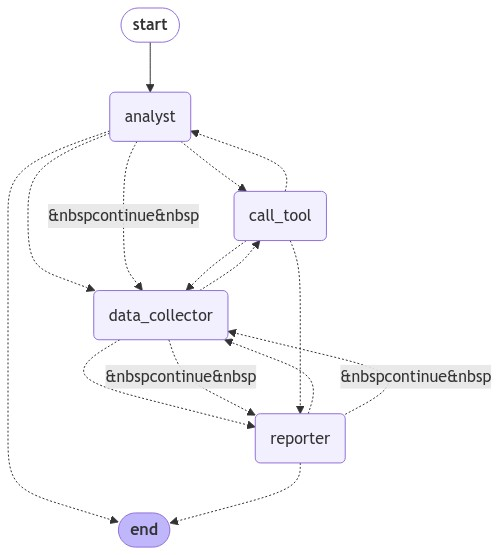

In [2]:
from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [9]:
# import utils
result = submitUserMessage("วิเคราะห์ร้านอาหารไทยแถวลุมพินี เซ็นเตอร์ ลาดพร้าว วิเคราะห์ความเป็นไปได้ถ้าต้องการขายข้าวในราคา 3000 บาท", keep_chat_history=True, return_reference=True, verbose=True)
utils.notify(sound_effect="purr")

================================== Ai Message ==================================
Name: analyst
Tool Calls:
  find_place_from_text (call_VVPuPVgiZs1OY0Q14mgp6Jii)
 Call ID: call_VVPuPVgiZs1OY0Q14mgp6Jii
  Args:
    location: ลุมพินี เซ็นเตอร์ ลาดพร้าว
  restaurant_sale_projection (call_btwDbGSrQje7xeoORcqX3OpK)
 Call ID: call_btwDbGSrQje7xeoORcqX3OpK
  Args:
    input_dict: {'base_price': 3000, 'category': 'Rice Bowl'}
================================= Tool Message =================================
Name: find_place_from_text


    address: 60 127 ซอย ลาดพร้าว 111 แขวงคลองจั่น เขตบางกะปิ กรุงเทพมหานคร 10240 ไทย

    location_name: ลุมพินี เซ็นเตอร์ ลาดพร้าว 111

    
================================== Ai Message ==================================
Name: analyst

### รายงานการวิเคราะห์ความเป็นไปได้ของร้านอาหารไทยแถวลุมพินี เซ็นเตอร์ ลาดพร้าว

#### 1. สรุป
- **ภาพรวม:** การวิเคราะห์นี้มุ่งเน้นไปที่การเปิดร้านอาหารไทยที่ขายข้าวในราคา 3,000 บาท แถวลุมพินี เซ็นเตอร์ ลาดพร้าว โดยมีการวิเคราะห์ต

In [7]:
submitUserMessage("ต้องการขายข้าวในราคา 3", keep_chat_history=True, return_reference=True, verbose=True)

================================== Ai Message ==================================
Name: analyst
Tool Calls:
  restaurant_sale_projection (call_xFkHOw03E9FCgdHxn7nERsDy)
 Call ID: call_xFkHOw03E9FCgdHxn7nERsDy
  Args:
    input_dict: {'base_price': 3, 'category': 'Rice Bowl'}
================================= Tool Message =================================
Name: restaurant_sale_projection

sale projection of Rice Bowl:
week	number of order	sale(forecast)
1	849	2,547
5	2,252	6,756
52	800	2,401

================================== Ai Message ==================================
Name: analyst

FINALANSWER

การขายข้าวในราคา 3 บาทมีการคาดการณ์ยอดขายดังนี้:

- **สัปดาห์ที่ 1:** 849 ออร์เดอร์, ยอดขาย 2,547 บาท
- **สัปดาห์ที่ 5:** 2,252 ออร์เดอร์, ยอดขาย 6,756 บาท
- **สัปดาห์ที่ 52:** 800 ออร์เดอร์, ยอดขาย 2,401 บาท

อย่างไรก็ตาม การตั้งราคา 3 บาทอาจทำให้ไม่สามารถครอบคลุมต้นทุนได้ และอาจส่งผลต่อความสามารถในการทำกำไรของร้านได้ ควรพิจารณาการตั้งราคาในช่วงที่สูงกว่านี้เพื่อให้สามารถทำกำไรได้มากขึ้น.


('\n\nการขายข้าวในราคา 3 บาทมีการคาดการณ์ยอดขายดังนี้:\n\n- **สัปดาห์ที่ 1:** 849 ออร์เดอร์, ยอดขาย 2,547 บาท\n- **สัปดาห์ที่ 5:** 2,252 ออร์เดอร์, ยอดขาย 6,756 บาท\n- **สัปดาห์ที่ 52:** 800 ออร์เดอร์, ยอดขาย 2,401 บาท\n\nอย่างไรก็ตาม การตั้งราคา 3 บาทอาจทำให้ไม่สามารถครอบคลุมต้นทุนได้ และอาจส่งผลต่อความสามารถในการทำกำไรของร้านได้ ควรพิจารณาการตั้งราคาในช่วงที่สูงกว่านี้เพื่อให้สามารถทำกำไรได้มากขึ้น.',
 'sale projection of Rice Bowl:\nweek\tnumber of order\tsale(forecast)\n1\t849\t2,547\n5\t2,252\t6,756\n52\t800\t2,401\n\n')

In [5]:
submitUserMessage("if i it passible to sell rice 10 bath each.", keep_chat_history=True, return_reference=True, verbose=True)

================================== Ai Message ==================================
Name: analyst
Tool Calls:
  restaurant_sale_projection (call_FpbflPBvRnBAYSVUW5J4uODL)
 Call ID: call_FpbflPBvRnBAYSVUW5J4uODL
  Args:
    input_dict: {'base_price': 10, 'category': 'Rice Bowl'}
  restaurant_sale_projection (call_jkK1NYQViFsaCn7INo8GLJHd)
 Call ID: call_jkK1NYQViFsaCn7INo8GLJHd
  Args:
    input_dict: {'base_price': 300, 'category': 'Rice Bowl'}
================================= Tool Message =================================
Name: restaurant_sale_projection

sale projection of Rice Bowl:
week	number of order	sale(forecast)
1	849	8,489
5	2,252	22,521
52	800	8,003

================================== Ai Message ==================================
Name: analyst

FINALANSWER

การขายข้าวในราคา 10 บาทต่อจานมีการคาดการณ์ยอดขายดังนี้:

- **สัปดาห์ที่ 1:** 849 ออร์เดอร์, ยอดขาย 8,489 บาท
- **สัปดาห์ที่ 5:** 2,252 ออร์เดอร์, ยอดขาย 22,521 บาท
- **สัปดาห์ที่ 52:** 800 ออร์เดอร์, ยอดขาย 8,003 บาท

เมื่อ

('\n\nการขายข้าวในราคา 10 บาทต่อจานมีการคาดการณ์ยอดขายดังนี้:\n\n- **สัปดาห์ที่ 1:** 849 ออร์เดอร์, ยอดขาย 8,489 บาท\n- **สัปดาห์ที่ 5:** 2,252 ออร์เดอร์, ยอดขาย 22,521 บาท\n- **สัปดาห์ที่ 52:** 800 ออร์เดอร์, ยอดขาย 8,003 บาท\n\nเมื่อเปรียบเทียบกับการขายข้าวในราคา 300 บาท:\n\n- **สัปดาห์ที่ 1:** 635 ออร์เดอร์, ยอดขาย 190,620 บาท\n- **สัปดาห์ที่ 5:** 2,335 ออร์เดอร์, ยอดขาย 700,410 บาท\n- **สัปดาห์ที่ 52:** 686 ออร์เดอร์, ยอดขาย 205,740 บาท\n\nจากการวิเคราะห์พบว่าการขายข้าวในราคา 10 บาทต่อจานนั้นมียอดขายที่ต่ำมากเมื่อเปรียบเทียบกับการขายในราคา 300 บาท ซึ่งอาจทำให้ไม่สามารถทำกำไรได้เพียงพอ ดังนั้นการขายข้าวในราคา 10 บาทอาจไม่เป็นทางเลือกที่ดีในแง่ของความสามารถในการทำกำไร.',
 'sale projection of Rice Bowl:\nweek\tnumber of order\tsale(forecast)\n1\t849\t8,489\n5\t2,252\t22,521\n52\t800\t8,003\n\nsale projection of Rice Bowl:\nweek\tnumber of order\tsale(forecast)\n1\t635\t190,620\n5\t2,335\t700,410\n52\t686\t205,740\n\n')